There are 881 samples (rows) representing five distinct cancer subtypes. Each sample has gene expression values for 20,531 genes (columns). The dataset is available from the UC Irvine Machine Learning Repository, but you can use the Python code below to obtain the data programmatically.

To follow along with the examples below, you can download the source code by clicking on the following link:

### Building a K-Means Clustering Pipeline

In [1]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

### Download and extract the TCGA dataset from UCI:

In [2]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"

In [3]:
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

In [4]:
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

In [5]:
r = urllib.request.urlretrieve (full_download_url, archive_name)

In [7]:
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

EOFError: Compressed file ended before the end-of-stream marker was reached

After the download and extraction is completed, you should have a directory that looks like this:

TCGA-PANCAN-HiSeq-801x20531/
|
├── data.csv
└── labels.csv

### Writing Your First K-Means Clustering Code in Python

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
features, true_labels = make_blobs(
n_samples=200,
centers=3,
cluster_std=2.75,
random_state=42
)

In [4]:
features[:5]

array([[  9.77075874,   3.27621022],
       [ -9.71349666,  11.27451802],
       [ -6.91330582,  -9.34755911],
       [-10.86185913, -10.75063497],
       [ -8.50038027,  -4.54370383]])

In [5]:
true_labels[:5]

array([1, 0, 2, 2, 2])

 you’ll use the StandardScaler class. This class implements a type of feature scaling called standardization. Standardization scales, or shifts, the values for each numerical feature in your dataset so that the features have a mean of 0 and standard deviation of 1:

In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [7]:
scaled_features[:5]

array([[ 2.13082109,  0.25604351],
       [-1.52698523,  1.41036744],
       [-1.00130152, -1.56583175],
       [-1.74256891, -1.76832509],
       [-1.29924521, -0.87253446]])

Now the data are ready to be clustered. The KMeans estimator class in scikit-learn is where you set the algorithm parameters before fitting the estimator to the data. The scikit-learn implementation is flexible, providing several parameters that can be tuned.

Here are the parameters used in this example:

init controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "random". Setting this to "k-means++" employs an advanced trick to speed up convergence, which you’ll use later.

n_clusters sets k for the clustering step. This is the most important parameter for k-means.

n_init sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

max_iter sets the number of maximum iterations for each initialization of the k-means algorithm.

Instantiate the KMeans class with the following arguments:

In [8]:
kmeans = KMeans(
init="random",
n_clusters=3,
n_init=10,
max_iter=300,
random_state=42
)

The parameter names match the language that was used to describe the k-means algorithm earlier in the tutorial. Now that the k-means class is ready, the next step is to fit it to the data in scaled_features. This will perform ten runs of the k-means algorithm on your data with a maximum of 300 iterations per run:

In [9]:
kmeans.fit(scaled_features)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

Statistics from the initialization run with the lowest SSE are available as attributes of kmeans after calling .fit():

In [10]:
kmeans.inertia_

74.57960106819853

In [11]:
kmeans.cluster_centers_

array([[-0.25813925,  1.05589975],
       [-0.91941183, -1.18551732],
       [ 1.19539276,  0.13158148]])

In [12]:
kmeans.n_iter_

2

Finally, the cluster assignments are stored as a one-dimensional NumPy array in kmeans.labels_. Here’s a look at the first five predicted labels:

In [13]:
kmeans.labels_[:5]

array([2, 0, 1, 1, 1])

### Choosing the Appropriate Number of Clusters

## To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE:

In [14]:
kmeans_kwargs = {
            "init": "random",
            "n_init": 10,
            "max_iter": 300,
            "random_state": 42,
  }

## # A list holds the SSE values for each k

In [15]:
sse = []

In [16]:
for k in range(1, 11):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(scaled_features)
            sse.append(kmeans.inertia_)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

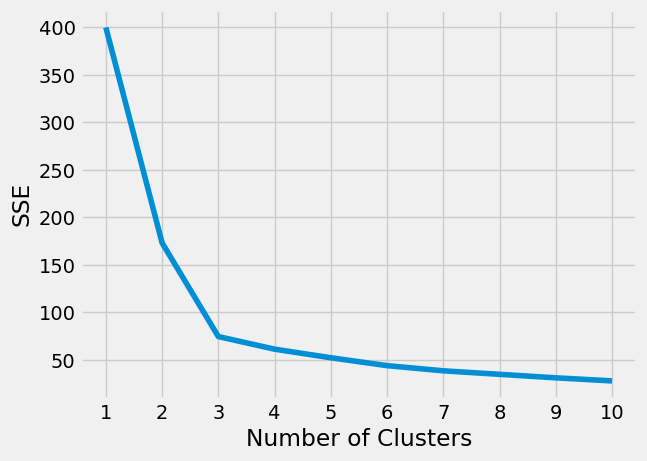

In [18]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

## Determining the elbow point in the SSE curve isn’t always straightforward. If you’re having trouble choosing the elbow point of the curve, then you could use a Python package, kneed, to identify the elbow point programmatically:

In [21]:
from kneed import KneeLocator

In [22]:
kl = KneeLocator(
        range(1, 11), sse, curve="convex", direction="decreasing"
)

In [23]:
kl.elbow

3

## The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

How close the data point is to other points in the cluster
How far away the data point is from points in other clusters
Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In the scikit-learn implementation of the silhouette coefficient, the average silhouette coefficient of all the samples is summarized into one score. The silhouette score() function needs a minimum of two clusters, or it will raise an exception.

Loop through values of k again. This time, instead of computing SSE, compute the silhouette coefficient:

In [24]:
silhouette_coefficients = []

In [25]:
for k in range(2, 11):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(scaled_features)
            score = silhouette_score(scaled_features, kmeans.labels_)
            silhouette_coefficients.append(score)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

## Plotting the average silhouette scores for each k shows that the best choice for k is 3 since it has the maximum score:

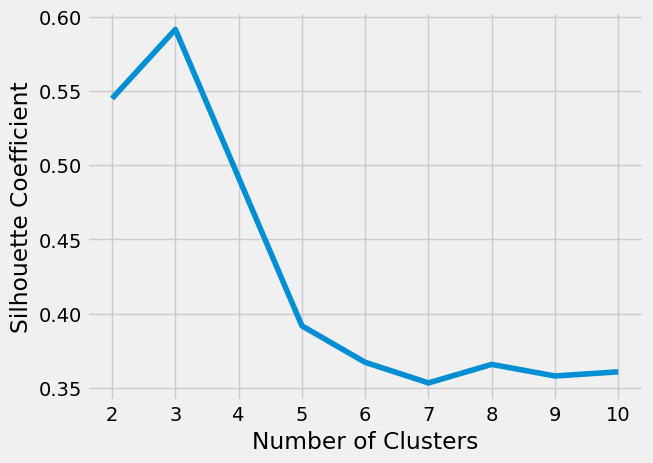

In [26]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Ultimately, your decision on the number of clusters to use should be guided by a combination of domain knowledge and clustering evaluation metrics.